In [3]:
from dataclasses import dataclass
import math
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

from scipy.stats import norm, gaussian_kde


import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

from typing import List, Dict, Tuple

import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))
from notebooks.helper_functions import get_var_colors, get_n_cue_colors, save_plot_as_svg

In [4]:
np.random.seed(42)

In [5]:
INITIAL_SAMPLE_SIZE = 100000
var_colors = get_var_colors()
n_cues_colors = get_n_cue_colors()


## Utils

### Data Class

In [6]:
# ------------------------------------------------------------------ #
#  Datenklasse für Variablenparameter                                #
# ------------------------------------------------------------------ #
@dataclass
class VariableParameters:
    """
    Hyperparameter einer Einzelvariable.

    Attribute:
      name       : Name der Variable
      accuracy   : gewünschte Bayes-Accuracy
      labels     : List[label_E0, label_E1]
      coef       : Steigungsparameter a
      intercept  : Achsenabschnitt b
      sigma      : Standardabweichung sigma
    """

    name: str
    accuracy: float
    labels: List[str]
    coef: float
    intercept: float
    sigma: float

### Plotting functions

In [7]:
def global_plot_range(hparams) -> Tuple[float, float]:
    """
    Compute global x-range for plotting all variables.

    Parameters
    ----------
    hparams : list of dicts
        Each dict must contain
        { 'a': float, 'sigma': float, 'b': float (optional, default 0) }

    Returns
    -------
    x_min, x_max
    """
    min_val = float("inf")
    max_val = float("-inf")
    for hp in hparams:
        a = hp.coef
        s = hp.sigma
        b = hp.intercept

        mu0 = b
        mu1 = b + a
        num_sigmas = 3

        min_val = min(min_val, mu0 - num_sigmas * s, mu1 - num_sigmas * s)
        max_val = max(max_val, mu0 + num_sigmas * s, mu1 + num_sigmas * s)

    return min_val, max_val


# call plot range function
# x_min, x_max = global_plot_range(variables.values())
# x_min, x_max = int(np.floor(x_min)), int(np.ceil(x_max))

# x_min, x_max

In [8]:
def _plot_all_variables(variables: Dict[str, VariableParameters], xlim: Tuple[float, float] = (-5, 5)) -> Figure:
    """
    Plot the conditional normal densities for all variables in the dictionary except for 'E' in one row.
    
    The function plots, for each variable (except 'E'), the two conditional normal densities (for E=0 and E=1)
    along with their means and the overlap area.
    
    Args:
        variables (Dict[str, VariableParameters]): Dictionary of VariableParameters for each variable.
        xlim (Optional[Tuple[float, float]]): x-axis limits for the plots. Defaults to (-5, 5).
        
    Returns:
        None: Displays the combined plot.
    """
    # Filter out variable 'E'
    non_e_vars = {k: v for k, v in variables.items() if k != "E"}
    n_vars = len(non_e_vars)
    
    # Create subplots in one row
    height=5
    fig, axes = plt.subplots(1, n_vars, figsize=(0.9*height * n_vars, height))
    if n_vars == 1:
        axes = [axes]
    
    for ax, (key, vp), colors in zip(axes, non_e_vars.items(), var_colors):
        a = vp.coef
        b = vp.intercept
        sigma = vp.sigma
        acc = vp.accuracy
        
        x_vals = np.linspace(xlim[0], xlim[1], 800)
        f0 = (1 / (math.sqrt(2 * math.pi) * sigma)) * np.exp(-((x_vals - b) ** 2) / (2 * sigma**2))
        f1 = (1 / (math.sqrt(2 * math.pi) * sigma)) * np.exp(-((x_vals - (a + b)) ** 2) / (2 * sigma**2))
        ax.plot(x_vals, f0, color=colors[0], label=f"{vp.name} | E=0")
        ax.plot(x_vals, f1, color=colors[1], label=f"{vp.name} | E=1")
        
        y_val0 = 1 / (math.sqrt(2 * math.pi) * sigma)
        y_val1 = 1 / (math.sqrt(2 * math.pi) * sigma)
        ax.plot([b, b], [0, y_val0], linestyle="--", color=colors[0], label=f"$\\mu_0$ = {b:5.3f} | E=0")
        ax.plot([a + b, a + b], [0, y_val1], linestyle="--", color=colors[1], label=f"$\\mu_1=${a + b:5.3f} | E=1")
        ax.fill_between(x_vals, 0, np.minimum(f0, f1), color=colors[1], alpha=0.3, label="Ambiguitätsbereich")
        
        ax.set_title(f"Optimalverteilung: {vp.name}\n(a={a:5.3f}, b={b:5.3f}, $\\sigma$={sigma:5.3f})\n\nAccuracy: {acc:5.3f}")
        ax.set_xlabel(f"{vp.name} ({key})")
        ax.set_ylabel("Wahrscheinlichkeitsdichte")
        ax.set_xlim(xlim)
        ax.set_ylim(0,0.7)
        
        ax.legend(loc="upper right", fontsize=11)
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return fig   

In [9]:
def _plot_all_emp_variables(variables: Dict[str, dict], xlim: Tuple[float, float] = (-5, 5)) -> None:
    """
    Plot the conditional normal densities for all variables in the dictionary (except 'E')
    using the empirical parameters.

    Args:
        variables (Dict[str, dict]): Dictionary of variable parameters (contains empirical values).
        xlim (Tuple[float, float]): x-axis limits for the plots.
        
    Returns:
        None
    """
    # Filter out variable 'E'
    non_e_vars = {k: v for k, v in variables.items() if k != "E"}
    n_vars = len(non_e_vars)
    
    # Create subplots in one row
    fig, axes = plt.subplots(1, n_vars, figsize=(6 * n_vars, 4))
    if n_vars == 1:
        axes = [axes]
    
    for ax, (key, vp), colors in zip(axes, non_e_vars.items(), var_colors):
        mean0 = vp["empirical_mean_e0"]
        mean1 = vp["empirical_mean_e1"]
        sigma0 = vp["empirical_std_e0"]
        sigma1 = vp["empirical_std_e1"]

        x_vals = np.linspace(xlim[0], xlim[1], 800)
        f0 = norm.pdf(x_vals, loc=mean0, scale=sigma0)
        f1 = norm.pdf(x_vals, loc=mean1, scale=sigma1)
        
        ax.plot(x_vals, f0, color=colors[0], label=f"{vp['name']} | E=0")
        ax.plot(x_vals, f1, color=colors[1], label=f"{vp['name']} | E=1")
        ax.axvline(mean0, linestyle="--", color=colors[0], label=f"μ0 = {np.round(mean0, 3)}\nσ0 = {np.round(sigma0, 3)}")
        ax.axvline()
        ax.axvline(mean1, linestyle="--", color=colors[1], label=f"μ1 = {np.round(mean1, 3)}\nσ1 = {np.round(sigma1, 3)}")
        # fill the area between mu-sigma and mu+sigma for both distributions
        ax.fill_between(
            x_vals, 0,
            np.where((x_vals < mean0 + sigma0) & (x_vals > mean0 - sigma0), f0, 0),
            color=colors[0], alpha=0.2
        )
        ax.fill_between(
            x_vals, 0,
            np.where((x_vals < mean1 + sigma1) & (x_vals > mean1 - sigma1), f1, 0),
            color=colors[1], alpha=0.2
        )
        ax.fill_between(x_vals, 0, np.minimum(f0, f1), color="grey", alpha=0.3, hatch='//', label="Overlap")
        ax.set_title(f"{vp['name']}")
        ax.set_xlabel(vp['name'])
        ax.set_xlim(xlim)
        ax.set_ylim(0, 0.7)
        ax.legend()
        ax.grid(True)
    #plt.title("Optimal Distributions of Variables R, T and H given the empirical means and stds (E=0 and E=1)")
    plt.tight_layout()
    plt.show()


In [10]:
def plot_empirical_distributions(
    stimuli_df: pd.DataFrame,
    variables: Dict[str, VariableParameters],
    xlim: Tuple[float, float] = (-5, 5),
    ylim: float = 0.5,
) -> Figure:
    """
    Plots the empirical distributions of the variables in the stimuli DataFrame.

    Args:
        stimuli_df (pd.DataFrame): DataFrame containing the stimuli data.
        variables (Dict[str, VariableParameters]): Dictionary of VariableParameters for each variable.
        xlim (Optional[Tuple[float, float]]): x-axis limits for the plots. Defaults to None.

    Returns:
        None: Displays the plots of the empirical distributions.
    """
    x = np.linspace(xlim[0], xlim[1], 800)
    filtered_vars = {key: vp for key, vp in variables.items() if key != "E"}
    subset_e1 = stimuli_df[stimuli_df["E"] == 1]
    subset_e0 = stimuli_df[stimuli_df["E"] == 0]
    height=5.75
    fig, axes = plt.subplots(1, len(filtered_vars), figsize=(2.8*height, height))
    for ax, (key, vp), colors in zip(axes, filtered_vars.items(), var_colors):
        sns.kdeplot(
            data=subset_e0,
            x=key,
            fill=True,
            common_norm=False,
            color=colors[0],
            alpha=0.5,
            label=f"Emp. Dichte ({key}) | E=0",
            ax=ax,
        )
        sns.kdeplot(
            data=subset_e1,
            x=key,
            fill=True,
            common_norm=False,
            color=colors[1],
            alpha=0.5,
            label=f"Emp. Dichte ({key}) | E=1",
            ax=ax,
        )
        emp_mu0 = subset_e0[key].mean()
        emp_mu1 = subset_e1[key].mean()
        kde0 = gaussian_kde(subset_e0[key])
        kde1 = gaussian_kde(subset_e1[key])
        density0 = kde0(emp_mu0)
        density1 = kde1(emp_mu1)
        ax.plot([emp_mu0, emp_mu0], [0, density0[0]], color=colors[0], label=f"Emp. $\\hat{{\\mu}}_0=${emp_mu0:5.3f} | E=0")
        ax.plot([emp_mu1, emp_mu1], [0, density1[0]], color=colors[1], label=f"Emp. $\\hat{{\\mu}}_1=${emp_mu1:5.3f} | E=1")
        
        # plot the theoretical normal distributions
        a = vp.coef
        b = vp.intercept
        sigma = vp.sigma
        mu0 = b
        mu1 = b + a
        f0 = (1 / (math.sqrt(2 * math.pi) * sigma)) * np.exp(-((x - mu0) ** 2) / (2 * sigma**2))
        f1 = (1 / (math.sqrt(2 * math.pi) * sigma)) * np.exp(-((x - mu1) ** 2) / (2 * sigma**2))
        ax.plot(x, f0, color=colors[0], linestyle="--", label=f"Opt. Dichte | E=0")
        ax.plot(x, f1, color=colors[1], linestyle="--", label=f"Opt. Dichte | E=1")
        
        f0_mu = 1 / (math.sqrt(2 * math.pi) * sigma)
        f1_mu = 1 / (math.sqrt(2 * math.pi) * sigma)
        ax.plot([mu0, mu0], [0, f0_mu], linestyle=":", color=colors[0], label=f"$\\mu_0=${mu0:5.3f} | E=0")
        ax.plot([mu1, mu1], [0, f1_mu], linestyle=":", color=colors[1], label=f"$\\mu_1=${mu1:5.3f} | E=1")
        
        ax.legend(loc='upper right', fontsize=11)

        ax.set_title(f"Empirische Verteilung: {vp.name}")
        ax.set_xlabel(f"{vp.name} ({key})")
        ax.set_ylabel("Wahrscheinlichkeitsdichte")
        ax.set_xlim(xlim)
        ax.set_ylim(0, ylim)
        ax.grid()
    plt.tight_layout()    
    plt.show()
    
    return fig  

### Get statistics about stimuli

In [11]:
def print_stimuli_statistics(stimuli_df: pd.DataFrame, variables: Dict[str, VariableParameters]):
    """
    Prints statistics of the stimuli including empirical means and standard deviations of the variables.

    Args:
        stimuli_df (pd.DataFrame): DataFrame containing the stimuli data.
        variables (Dict[str, VariableParameters]): Dictionary of VariableParameters for each variable.
    """
    print("\n[Stimuli Statistics]")
    subset_e0 = stimuli_df[stimuli_df['E'] == 0]
    subset_e1 = stimuli_df[stimuli_df['E'] == 1]
    
    for var in variables:
        if var == "E":
            continue
        mean_e0 = subset_e0[var].mean()
        mean_e1 = subset_e1[var].mean()
        std_dev_e0 = subset_e0[var].std()
        std_dev_e1 = subset_e1[var].std()
        print(
            f"{var}:\n  Empirical Mean (E=0): {mean_e0:.3f}, Empirical Mean (E=1): {mean_e1:.3f},"
            f"\n  Std Dev (E=0)= {std_dev_e0:.3f}, Std Dev (E=1)= {std_dev_e1:.3f}"
            )
        print(
            f"\n  Target Mean (E=0): {variables[var].intercept:.3f}, Target Mean (E=1): {variables[var].coef + variables[var].intercept:.3f}"
            f"\n  Target Std Dev: {variables[var].sigma:.3f}"
            "\n___\n"
        )

### PP- und QQ-Plots

In [12]:
def plot_pp_qq_per_variable(df: pd.DataFrame, variables: dict) -> Figure:
    """
    Creates PP- and QQ-plots comparing the empirical and theoretical distributions
    of each observed variable in the stimulus set.

    Args:
        df (pd.DataFrame): DataFrame with selected stimuli.
        variables (dict): Dictionary of VariableParameters.
    """
    observed_vars = [var for var in variables if var != "E"]
    fig, all_axes = plt.subplots(len(observed_vars), 4, figsize=(20, 5))

    for var, colors, axes in zip(observed_vars, var_colors, all_axes):
        vp = variables[var]
        # Create a figure with 4 subplots in one row: PP-plot and QQ-plot for E=0 and E=1
        for i, e_val in enumerate([0, 1]):
            # Select data for the current E value
            subset = df[df["E"] == e_val]
            x = subset[var].sort_values().values
            n = len(x)
            clr = colors[0] if e_val == 0 else colors[1]
            if n < 2:
                axes[2 * i].set_title(
                    f"PP-Plot: {var} (E={e_val})\nToo few data points"
                )
                axes[2 * i + 1].set_title(
                    f"QQ-Plot: {var} (E={e_val})\nToo few data points"
                )
                axes[2 * i].axis("off")
                axes[2 * i + 1].axis("off")
                continue

            # Compute the empirical CDF
            empirical_cdf = np.linspace(1 / (n + 1), n / (n + 1), n)

            # Theoretical parameters for the current E value
            mu_theoretical = vp.coef * e_val + vp.intercept

            # PP-Plot for current E value
            theoretical_cdf = norm.cdf(x, loc=mu_theoretical, scale=vp.sigma)
            axes[2 * i].plot(
                theoretical_cdf,
                empirical_cdf,
                "o",
                ms=4,
                color=clr,
                mec="black",
                mew=0.5,
                label=f"Stimuli E={e_val}"
            )
            axes[2 * i].plot([0, 1], [0, 1], "k--", label="Ideal")
            axes[2 * i].set_xlabel("Theoretical CDF")
            axes[2 * i].set_ylabel("Empirical CDF")
            axes[2 * i].set_title(f"PP-Plot: {var} (E={e_val})")
            axes[2 * i].grid(True)
            axes[2 * i].legend()

            # QQ-Plot for current E value
            theoretical_q = norm.ppf(empirical_cdf, loc=mu_theoretical, scale=vp.sigma)
            axes[2 * i + 1].plot(
                theoretical_q,
                x,
                "o",
                ms=4,
                color=clr,
                mec="black",
                mew=0.5,
                label=f"Stimuli E={e_val}"
            )
            axes[2 * i + 1].plot(
                [theoretical_q.min(), theoretical_q.max()],
                [theoretical_q.min(), theoretical_q.max()],
                "k--",
                label="Ideal",
            )
            axes[2 * i + 1].set_xlabel("Theoretical Quantiles")
            axes[2 * i + 1].set_ylabel("Empirical Quantiles")
            axes[2 * i + 1].set_xlim(-5,5)
            axes[2 * i + 1].set_ylim(-5,5)
            axes[2 * i + 1].set_title(f"QQ-Plot: {var} (E={e_val})")
            axes[2 * i + 1].grid(True)
            axes[2 * i + 1].legend()
        plt.tight_layout()
        plt.show()
        
    return fig          

### Save DF as file

In [13]:
def save_to_csv(df: pd.DataFrame, filename: str) -> None:
    if not filename.endswith(".csv"):
        raise ValueError("Filename must end with .csv")
    display(df)
    df.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

In [14]:
def save_as_file(
    parameters: Dict[str, VariableParameters], filename: str
) -> pd.DataFrame:
    """
    Save the hyperparameters to a CSV file and return the corresponding DataFrame. This function converts a dictionary of VariableParameters objects into a pandas DataFrame,
    adds additional columns such as 'id' and 'observed', reorders the columns, and then saves it as a CSV file using the provided filename.

    Args:
        parameters (Dict[str, VariableParameters]): A dictionary where each key is a variable identifier and each value is a VariableParameters instance containing the hyperparameters.
        filename (str): The name of the CSV file to which the DataFrame will be saved. Must end with '.csv'.

    Raises:
        ValueError: If the filename does not end with '.csv'.

    Returns:
        pd.DataFrame: The DataFrame containing hyperparameter information for each variable.
    """
    if not filename.endswith(".csv"):
        raise ValueError("Filename must end with .csv")

    # Convert the parameters to a DataFrame
    df = pd.DataFrame.from_dict(
        {key: vars(param) for key, param in parameters.items()}, orient="index"
    )
    df.reset_index(inplace=True)
    df.rename(columns={"index": "Variable"}, inplace=True)

    # create a column 'id'
    df["id"] = df.index + 1

    # create a column 'Name' with the variable name
    df["name"] = df["Variable"].apply(
        lambda x: parameters[x].name if x in parameters else x
    )
    df["observed"] = df["Variable"].apply(lambda x: True if x != "E" else False)

    # Reorder columns
    df = df[
        [
            "id",
            "name",
            "Variable",
            "observed",
            "accuracy",
            "labels",
            "coef",
            "intercept",
            "sigma",
        ]
    ]
    save_to_csv(df, filename)

    return df

# 1. Initialize variables as a dictionary

In [15]:
# --- Schritt 1: Variablen initialisieren ---
variables = {
    "R": VariableParameters(
        name="Regenbogen",
        accuracy=0.65,  # target accuracy for the variable
        labels=["unsichtbar", "leuchtend"],
        coef=0.0,
        intercept=-2.2,
        sigma=0.7,
    ),
    "T": VariableParameters(
        name="Temperatur",
        accuracy=0.75,
        labels=["kühl", "warm"],
        coef=0.0,
        intercept=-0.4,
        sigma=1.3,
    ),
    "H": VariableParameters(
        name="Helligkeit",
        accuracy=0.85,
        labels=["dunkel", "hell"],
        coef=0.0,
        intercept=-0.1,
        sigma=1.0,
    ),
    "E": VariableParameters(
        name="Einhornsichtung",
        accuracy=1.0,
        labels=["kein Einhorn (0%)", "sicher Einhorn (100%)"],
        coef=1.0,
        intercept=0.0,
        sigma=0.0,
    ),
}

p_E = 0.5  # Prior P(E=1)

# 2. Find the right hyperparameters for our observed variables

Bayesian Cue Hyperparameter Generator: Automatically generates the parameter coef (a) for each observed variable
so that the Bayesian classifier achieves the desired accuracy. Uses SciPy for precise normal CDF and robust zero-point search.

In [16]:
def _adjust_params_to_match_accuracy(params: VariableParameters, p_E: float) -> VariableParameters:
    """
    Adjusts the parameter 'a' in the observation model R ~ N(a*E + b, sigma^2) such that the classification accuracy of predicting E from R matches the desired target accuracy.
    
    Args:
        params (VariableParameters): Instance of VariableParameters.
        p_E (float): Prior probability of E=1, must be between 0 and 1.    
    Raises:
        TypeError: If params is not an instance of VariableParameters.
        ValueError: If target_accuracy is not between p_E and 1 (exclusive).   
    Returns:
        VariableParameters: The updated VariableParameters instance with adjusted 'coef' corresponding to a.
    """
    # --- Step 1: Validate input ---
    if not isinstance(params, VariableParameters):
        raise TypeError("params must be an instance of VariableParameters.")
    target_accuracy = params.accuracy
    sigma = params.sigma
    
    # --- Step 2: Validate target accuracy ---
    if not (p_E < target_accuracy < 1.0):
        raise ValueError(f"target_accuracy must be between {p_E} and 1 (exclusive).")
    
    # --- Step 3: Convert target accuracy to required d' ---
    # Classification accuracy A = Φ(d' / sqrt(2)), where Φ is the standard normal CDF. --> d' = sqrt(2) * Φ⁻¹(A) (see thesis for explanation)
    z = norm.ppf(target_accuracy)  # inverse CDF (quantile) of the normal distribution
    d_prime = math.sqrt(2) * z  # Effect size d'
    
    # --- Step 4: Calculate the required coefficient parameter ---
    # d' = |coefficient| / sigma  →  coefficient = d' * sigma
    coefficient = d_prime * sigma
    
    # --- Step 5: Set the parameters in the dictionary ---
    params.coef = round(float(coefficient), 3)  # replaces any existing value

    return params

Adjusted parameters for all variables:

    R  a=0.381 b=-2.200 sigma=0.700 acc=0.65 labels=['unsichtbar', 'leuchtend']
    T  a=1.240 b=-0.400 sigma=1.300 acc=0.75 labels=['kühl', 'warm']
    H  a=1.466 b=-0.100 sigma=1.000 acc=0.85 labels=['dunkel', 'hell']
Optimal distributions of the observed variables given the optimal parameters for the desired target accuracy:


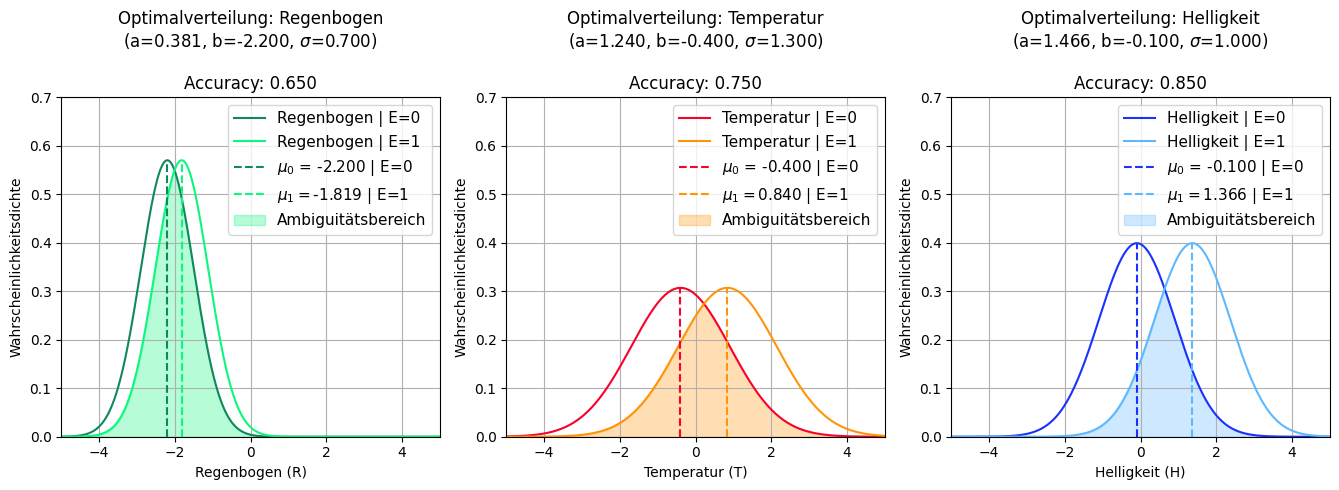

In [37]:
# --- Schritt 2: Parameter für alle Variablen anpassen ---
print(f"Adjusted parameters for all variables:\n")

for key, vp in variables.items():
    if key != "E":
        variables[key] = _adjust_params_to_match_accuracy(vp, p_E)
        print(f"    {key:<2} a={vp.coef:5.3f} b={vp.intercept:5.3f} sigma={vp.sigma:5.3f} acc={vp.accuracy:.2f} labels={vp.labels}")

print("Optimal distributions of the observed variables given the optimal parameters for the desired target accuracy:")
_plot_all_variables(variables=variables)
plt.show()

# 3. Create a set of stimuli 

In [18]:
def generate_stimuli(
    p_E: float, variables: Dict[str, VariableParameters], n_stimuli: int
) -> pd.DataFrame:
    """
    Generates a DataFrame of stimuli with columns for stimulus_id, E, R, T, and H.

    Args:
        p_E (float): Probability of E=1 (the prior probability of the event).
        variables (Dict[str, Dict[str, float]]): Dictionary containing the parameters for each variable, containing keys 'R', 'T', 'H' with their respective parameters.
        n_stimuli (int): Number of stimuli to generate.
    Returns:
        pd.DataFrame: DataFrame containing the generated stimuli with columns 'stimulus_id', 'E', 'R', 'T', and 'H'.
    Raises:
        ValueError: If p_E is not between 0 and 1.
    """
    print(variables)
    stimuli = pd.DataFrame(
        {"stimulus_id": np.arange(n_stimuli), "E": 0, "R": 0, "T": 0, "H": 0}
    )
    if not (0 <= p_E <= 1):
        raise ValueError("p_E must be between 0 and 1")

    # extract parameters for the current stimulus
    a = {key: variables[key].intercept for key in ["R", "T", "H"]}
    b = {key: variables[key].coef for key in ["R", "T", "H"]}
    sigma = {key: variables[key].sigma for key in ["R", "T", "H"]}

    E = np.random.binomial(1, p_E, size=n_stimuli)
    R = np.round(np.random.normal(loc=a["R"] + b["R"] * E, scale=sigma["R"], size=n_stimuli), decimals=2)
    T = np.round(np.random.normal(loc=a["T"] + b["T"] * E, scale=sigma["T"], size=n_stimuli), decimals=2)
    H = np.round(np.random.normal(loc=a["H"] + b["H"] * E, scale=sigma["H"], size=n_stimuli), decimals=2)

    # set E,R,T,H for all stimuli using vectorized assignment
    stimuli["E"] = E
    stimuli["R"] = R
    stimuli["T"] = T
    stimuli["H"] = H

    return stimuli

### Empirical distribution functions for initial stimulus set (n = 100,000)

The ```initial_stimulus_df``` contains 100,000 stimulus samples randomly generated with the optimal parameters and thus represents an approximately optimal stimulus distribution.

In [34]:
initial_stimuli_df = generate_stimuli(p_E=0.5, variables=variables, n_stimuli=INITIAL_SAMPLE_SIZE)

{'R': VariableParameters(name='Regenbogen', accuracy=0.65, labels=['unsichtbar', 'leuchtend'], coef=0.381, intercept=-2.2, sigma=0.7), 'T': VariableParameters(name='Temperatur', accuracy=0.75, labels=['kühl', 'warm'], coef=1.24, intercept=-0.4, sigma=1.3), 'H': VariableParameters(name='Helligkeit', accuracy=0.85, labels=['dunkel', 'hell'], coef=1.466, intercept=-0.1, sigma=1.0), 'E': VariableParameters(name='Einhornsichtung', accuracy=1.0, labels=['kein Einhorn (0%)', 'sicher Einhorn (100%)'], coef=1.0, intercept=0.0, sigma=0.0)}



Empirical distributions of the 100,000 randomly generated observed variables:


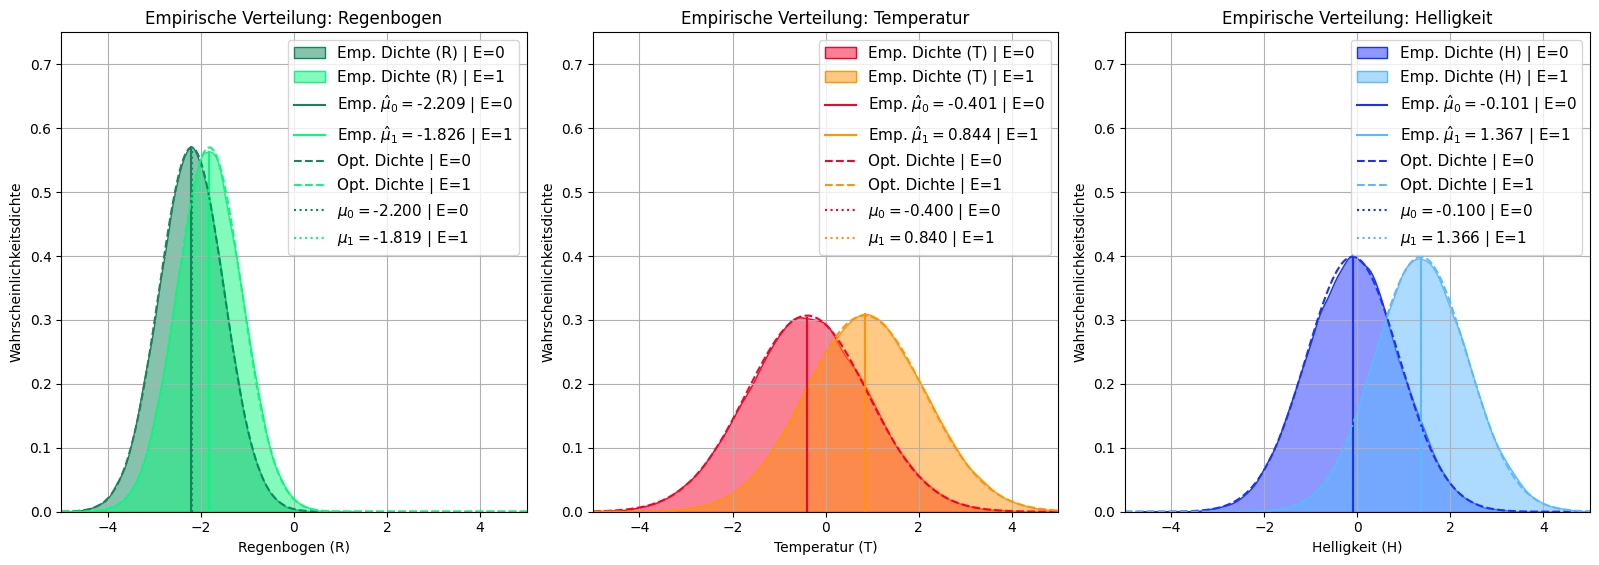

In [40]:
#print_stimuli_statistics(initial_stimuli_df, variables)

print("\nEmpirical distributions of the 100,000 randomly generated observed variables:")
fig = plot_empirical_distributions(
    stimuli_df=initial_stimuli_df,
    variables=variables,
    ylim=0.75,
)

### Empirical distribution functions for initial stimulus set (n = 100)

The ```new_100_stimuli_df``` contains 100 stimulus samples randomly generated with the optimal parameters and shows that a small sample size can lead to significant deviations when creating a stimulus set.

In [21]:
new_100_stimuli_df = generate_stimuli(
    p_E=0.5, 
    variables=variables, 
    n_stimuli=100,
)

{'R': VariableParameters(name='Regenbogen', accuracy=0.65, labels=['unsichtbar', 'leuchtend'], coef=0.381, intercept=-2.2, sigma=0.7), 'T': VariableParameters(name='Temperatur', accuracy=0.75, labels=['kühl', 'warm'], coef=1.24, intercept=-0.4, sigma=1.3), 'H': VariableParameters(name='Helligkeit', accuracy=0.85, labels=['dunkel', 'hell'], coef=1.466, intercept=-0.1, sigma=1.0), 'E': VariableParameters(name='Einhornsichtung', accuracy=1.0, labels=['kein Einhorn (0%)', 'sicher Einhorn (100%)'], coef=1.0, intercept=0.0, sigma=0.0)}



[Stimuli Statistics]
R:
  Empirical Mean (E=0): -2.201, Empirical Mean (E=1): -1.890,
  Std Dev (E=0)= 0.704, Std Dev (E=1)= 0.701

  Target Mean (E=0): -2.200, Target Mean (E=1): -1.819
  Target Std Dev: 0.700
___

T:
  Empirical Mean (E=0): -0.127, Empirical Mean (E=1): 0.790,
  Std Dev (E=0)= 1.497, Std Dev (E=1)= 1.202

  Target Mean (E=0): -0.400, Target Mean (E=1): 0.840
  Target Std Dev: 1.300
___

H:
  Empirical Mean (E=0): -0.056, Empirical Mean (E=1): 1.389,
  Std Dev (E=0)= 0.853, Std Dev (E=1)= 1.022

  Target Mean (E=0): -0.100, Target Mean (E=1): 1.366
  Target Std Dev: 1.000
___


Empirical distributions of the 100 randomly generated observed variables:


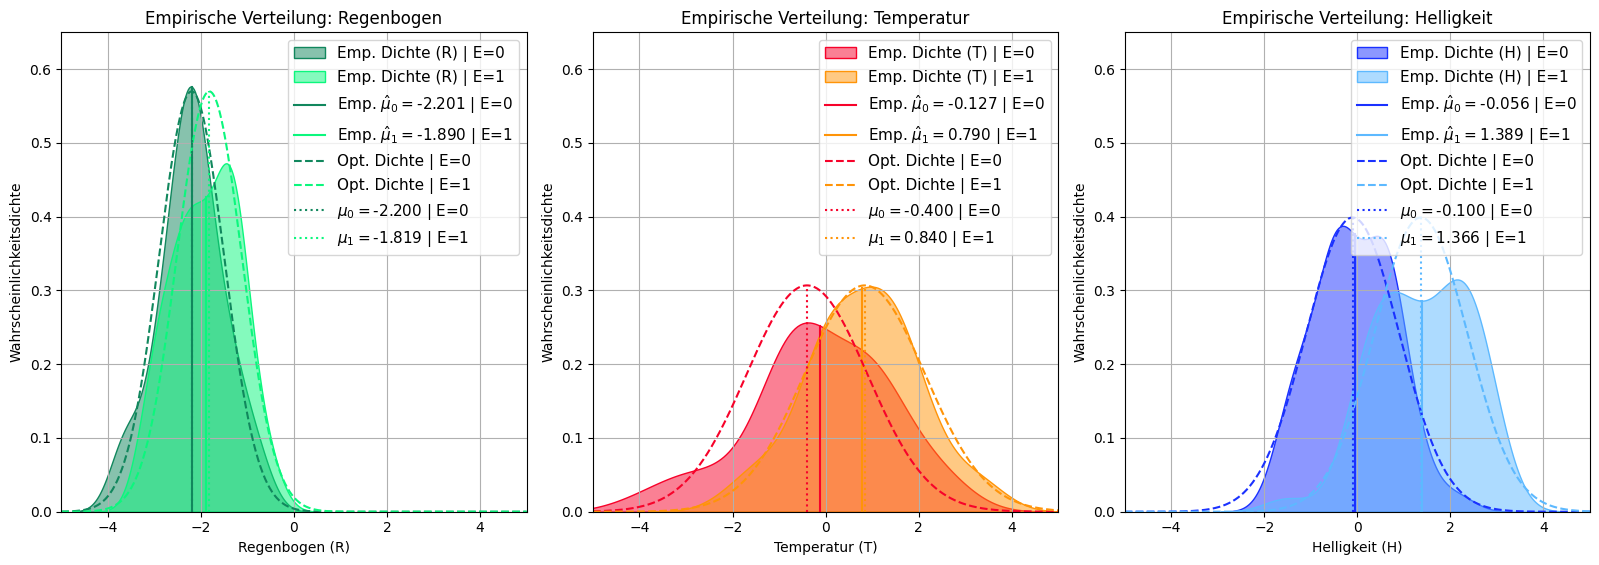

In [41]:
print_stimuli_statistics(new_100_stimuli_df, variables)

print("\nEmpirical distributions of the 100 randomly generated observed variables:")
fig = plot_empirical_distributions(
    stimuli_df=new_100_stimuli_df, #balanced_stimuli_df,
    variables=variables,
    ylim=0.65,
)

# 4. Informed Subsampling

### Problem
With 100,000 randomly generated stimuli, the distributions of the observed variables are already very similar to the theoretical distributions with the optimal hyperparameters for the desired predictive power at E (target accuracy). However, if only 100 samples are randomly drawn, each stimulus has a much higher weight in the overall distribution, which, due to the comparatively high dimensionality in connection with the small sample size, means that the empirical distributions of the observed variables of the 100 stimuli sometimes deviate enormously from the optimal distributions (though not necessarily for all variables), resulting in the target accuracy being significantly undershot in some cases. In the worst case, this can lead to test subjects being unable to correctly grasp the relationship between the cues and E because their predictive power for E is far too low.

### Solution
Target accuracy is achieved when the values of the observed variables are as close as possible to their optimal distributions with the calculated hyperparameters, i.e., they should have the same mean values for E=1 and E=0 as the target normal distributions.

To this end, batches of 100 stimuli are iteratively drawn from the 100,000 initially generated stimuli and, based on the match with the target normal distribution, i.e., target $\mu$ and target $\sigma$ for E=0 and E=1, each batch is examined to see whether all values lie within a tolerated range. 

The criteria are therefore:

- Empirical means and standard deviations should correspond to the target distributions +/- tolerance range
- The distribution of E should be within the range of $p(E=1) \in [0.4, 0.6]$
- All observed variables should be within the target range $(-5, 5)$ in order to be correctly mapped to the sliders (By definition, this is the case for the hyperparameters for the optimal distributions for almost all values except for a few outliers).

If a batch is found that meets all criteria, this batch is output as ```balanced_stimuli_df``` and used as the stimulus set for the experiment.

In [42]:
def select_best_stimuli_by_means(
    df: pd.DataFrame,
    variables: dict,
    n_samples: int = 100,
    e_ratio_bounds: Tuple[float, float] = (0.4, 0.6),
    max_iterations: int = 100000,
    tolerance: float = 0.05,
) -> Tuple[pd.DataFrame, Dict[str, Dict[str, float]]]:
    """
    Selects a subset of stimuli where the empirical means and standard deviations of each observed variable (R, T, H) match their target values 
    (based on E=0 and E=1) as closely as possible, and the E-values are balanced within the given range.

    Args:
        df (pd.DataFrame): Full stimulus dataframe.
        variables (dict): Dictionary of VariableParameters for each variable.
        n_samples (int): Number of stimuli to select.
        e_ratio_bounds (Tuple[float, float]): Acceptable bounds for the proportion of E=1.
        max_iterations (int): Maximum number of attempts.
        tolerance (float): Allowed relative deviation from the expected conditional means and standard deviations.
        plot (bool): Whether to plot the variables.

    Raises:
        RuntimeError: If no suitable stimulus subset is found after maximum iterations.
        
    Returns:
        pd.DataFrame: Selected stimulus subset.
    """
    x_min, x_max = (-5,5)
    # First, remove out-of-range values for the observed variables
    df = df[(df["R"] >= x_min) & (df["R"] <= x_max)]
    df = df[(df["T"] >= x_min) & (df["T"] <= x_max)]
    df = df[(df["H"] >= x_min) & (df["H"] <= x_max)]
    
    target_means = {}
    # Compute target conditional means for each observed variable based on E=0 and E=1
    for var, vp in variables.items():
        if var == "E":
            continue
        mean_e0 = vp.coef * 0 + vp.intercept
        mean_e1 = vp.coef * 1 + vp.intercept
        target_means[var] = (mean_e0, mean_e1)
    
    for _ in range(max_iterations):
        sample = df.sample(n_samples)
        e_ratio = sample["E"].mean()
        if not (e_ratio_bounds[0] <= e_ratio <= e_ratio_bounds[1]):
            continue

        all_within_tolerance = True
        for var, (target_e0, target_e1) in target_means.items():
            # Compute empirical means for E=0 and E=1:
            emp_e0 = sample[sample["E"] == 0][var].mean()
            emp_e1 = sample[sample["E"] == 1][var].mean()
            
            # Relative differences for means:
            rel_diff_mean_0 = abs(emp_e0 - target_e0) #/ max(abs(target_e0), 1e-6)
            rel_diff_mean_1 = abs(emp_e1 - target_e1) #/ max(abs(target_e1), 1e-6)
            
            # Compute empirical standard deviations for E=0 and E=1:
            emp_std_0 = sample[sample["E"] == 0][var].std()
            emp_std_1 = sample[sample["E"] == 1][var].std()
            
            # Use the target standard deviation from the variable parameters (sigma)
            target_std = variables[var].sigma
            rel_diff_std_0 = abs(emp_std_0 - target_std) #/ max(abs(target_std), 1e-6)
            rel_diff_std_1 = abs(emp_std_1 - target_std) #/ max(abs(target_std), 1e-6)
            
            if (rel_diff_mean_0 > tolerance or rel_diff_mean_1 > tolerance or
                rel_diff_std_0 > tolerance or rel_diff_std_1 > tolerance):
                all_within_tolerance = False
                break

        if all_within_tolerance:
            print("\n[Stimulus-Set Analyse – Mittelwerte und Standardabweichungen]")
            
            emp_variables = {}
            for var, (target_e0, target_e1) in target_means.items():
                emp_mean_e0 = sample[sample["E"] == 0][var].mean()
                emp_mean_e1 = sample[sample["E"] == 1][var].mean()
                emp_std_e0 = sample[sample["E"] == 0][var].std()
                emp_std_e1 = sample[sample["E"] == 1][var].std()
                print(
                    f"{var}:\n  mean(E=0): {emp_mean_e0:.3f} (target: {target_e0:.3f}), "
                    f"\n    mean(E=1): {emp_mean_e1:.3f} (target: {target_e1:.3f}) | "
                    f"\n    std(E=0): {emp_std_e0:.3f} (target: {variables[var].sigma:.3f}), "
                    f"\n    std(E=1): {emp_std_e1:.3f} (target: {variables[var].sigma:.3f})"
                )
                
                # save the empirical means and stds in a new empirical variable parameters dictionary
                emp_variables[var] = {
                    "name": variables[var].name,
                    "accuracy": variables[var].accuracy,
                    "labels": variables[var].labels,
                    "coef": variables[var].coef,
                    "intercept": variables[var].intercept,
                    "sigma": variables[var].sigma,
                    "empirical_mean_e0": emp_mean_e0,
                    "empirical_mean_e1": emp_mean_e1,
                    "empirical_std_e0": emp_std_e0,
                    "empirical_std_e1": emp_std_e1
                }
                
            print(
                f"\nE-Verteilung: E=1 in {e_ratio * 100:.1f}% der Stimuli "
                f"({int(e_ratio * n_samples)} von {n_samples})"
            )
            return sample.reset_index(drop=True), emp_variables

    raise RuntimeError("No suitable stimulus subset found after maximum iterations.")


### **Empirical distribution functions for balanced stimuli sets**

The balanced stimulus set contains 100 selected stimuli that best approximate the theoretical optimal distributions for all observed variables (i.e., whose empirical means and standard deviations deviate as little as possible from the theoretical optimal parameters).

In [43]:
# Select a balanced subset of stimuli based on empirical means (already generated, therefore use the generated file)

# CAUTION: this search process may take up to 20 minutes. Uncomment the following line to create a new balanced set of stimuli instead of using the pre-generated balanced stimuli.

# balanced_stimuli_df, empirical_variables_dict = select_best_stimuli_by_means(
#     df=initial_stimuli_df,
#     variables=variables,
#     n_samples=100,
#     e_ratio_bounds=(0.4, 0.6),
#     max_iterations=250000,
#     tolerance=0.06,
# )

# in case you don't want to use the pre-generated balanced stimuli, comment out the following line
balanced_stimuli_df = pd.read_csv("../psychopy/hyperparameter_and_stimuli/2025-06-15_13-07_all_balanced_stimuli.csv") # 


[Stimuli Statistics]
R:
  Empirical Mean (E=0): -2.216, Empirical Mean (E=1): -1.820,
  Std Dev (E=0)= 0.737, Std Dev (E=1)= 0.711

  Target Mean (E=0): -2.200, Target Mean (E=1): -1.819
  Target Std Dev: 0.700
___

T:
  Empirical Mean (E=0): -0.358, Empirical Mean (E=1): 0.846,
  Std Dev (E=0)= 1.239, Std Dev (E=1)= 1.276

  Target Mean (E=0): -0.400, Target Mean (E=1): 0.840
  Target Std Dev: 1.300
___

H:
  Empirical Mean (E=0): -0.078, Empirical Mean (E=1): 1.426,
  Std Dev (E=0)= 0.979, Std Dev (E=1)= 1.007

  Target Mean (E=0): -0.100, Target Mean (E=1): 1.366
  Target Std Dev: 1.000
___


Empirical distributions of the 100 selected observed variables:


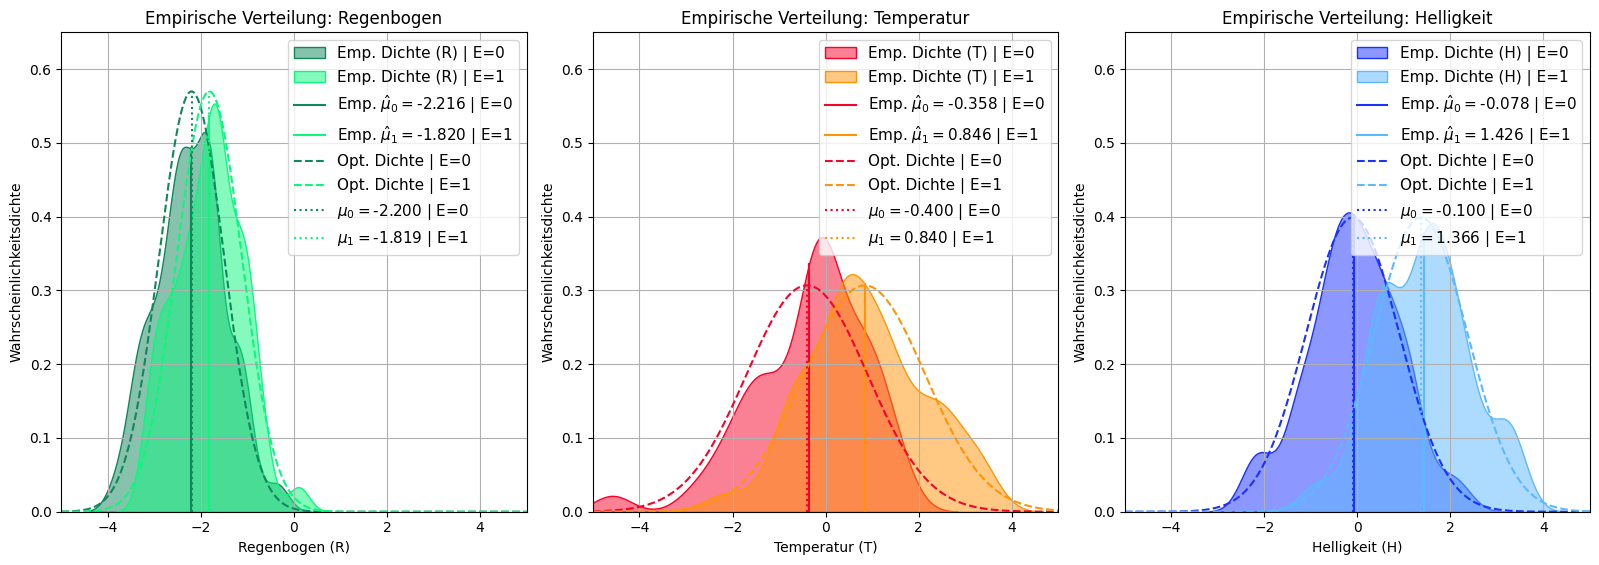

In [45]:
print_stimuli_statistics(balanced_stimuli_df, variables)

print("\nEmpirical distributions of the 100 selected observed variables:")
fig = plot_empirical_distributions(
    stimuli_df=balanced_stimuli_df, #balanced_stimuli_df,
    variables=variables,
    ylim=0.65,
)

### Save the Stimuli as CSV file

In [46]:
time_str = datetime.now().strftime("%Y-%m-%d_%H-%M")

# in case the user wants to save the variables and balanced stimuli:

#variables_df = save_as_file(variables, "hyperparameters.csv")
#save_to_csv(balanced_stimuli_df, f"{time_str}_balanced_stimuli.csv")

# 5. Create an extended Stimulus List

This list contains all possible permutations of the observed variables shown in the experiment introducing a new column 'permutation' that contains a list of strings indicating in which permutations the the observed variables are to be shown in the training and test phase.

In [27]:
def extend_stimuli_with_permutations(stimuli_df: pd.DataFrame) -> pd.DataFrame:
    """
    Extend the stimuli DataFrame by creating rows for each permutation of the observed variables.

    For each permutation defined in the 'test' key of the permutations dictionary,
    the function creates a copy of the original stimuli DataFrame, assigns
    the permutation to a new 'permutation' column, and concatenates all copies.

    Args:
        stimuli_df (pd.DataFrame): Original stimuli DataFrame with columns such as 'stimulus_id', 'E', etc.

    Returns:
        pd.DataFrame: Extended stimuli DataFrame with an additional 'permutation' column,
                      containing rows for each permutation.
    """
    permutations_dict = {
        "train": ["R", "T", "H"],
        "test": [
            ["R", "T", "H"],
            ["R", "H", "T"],
            ["T", "R", "H"],
            ["T", "H", "R"],
            ["H", "R", "T"],
            ["H", "T", "R"],
        ],
    }

    extended_stimuli = []
    for permutation in permutations_dict["test"]:
        df_copy = stimuli_df.copy()
        df_copy["permutation_train"] = [permutation[0]] * len(df_copy)
        df_copy["permutation_test"] = [permutation] * len(df_copy)
        extended_stimuli.append(df_copy)
        print(permutation)

    return pd.concat(extended_stimuli, ignore_index=True)

In [28]:
# scored_stimuli_with_permutations = extend_stimuli_with_permutations(scored_stimuli_df)
balanced_stimuli_with_permutations = extend_stimuli_with_permutations(
    balanced_stimuli_df
)

['R', 'T', 'H']
['R', 'H', 'T']
['T', 'R', 'H']
['T', 'H', 'R']
['H', 'R', 'T']
['H', 'T', 'R']


In [29]:
time_str = datetime.now().strftime("%Y-%m-%d_%H-%M")
print(time_str)

2025-08-09_20-06


### Split an existing balanced stimuli CSV into two groups for the test phase

In [47]:
extended_balanced_stimuli_from_csv = pd.read_csv('../psychopy/hyperparameter_and_stimuli/2025-06-15_13-07_all_balanced_stimuli.csv')

# df1 should contain [[R,T,H], [T,H,R], [H,R,T]]
# df2 should contain [[R,H,T], [T,R,H], [H,T,R]]
df1_permutations = [
    "['R', 'T', 'H']",
    "['T', 'H', 'R']",
    "['H', 'R', 'T']"
]

df2_permutations = [
    "['R', 'H', 'T']",
    "['T', 'R', 'H']",
    "['H', 'T', 'R']"
]

# split extended_stimuli into two sub_dataframes containing df1 and df2 permutations
extended_stimuli_group_1 = extended_balanced_stimuli_from_csv[extended_balanced_stimuli_from_csv['permutation_test'].isin(df1_permutations)]
extended_stimuli_group_2 = extended_balanced_stimuli_from_csv[extended_balanced_stimuli_from_csv['permutation_test'].isin(df2_permutations)]

display(extended_stimuli_group_1)
display(extended_stimuli_group_2)

# prove if each group_df contains all 100 stimuli from the train_stimuli_df via stimuli_ID
subset = [col for col in extended_balanced_stimuli_from_csv.columns if col != "permutation_test"]
train_stimuli_df = extended_balanced_stimuli_from_csv.copy().drop_duplicates(subset=subset)

fehlende_stimuli_g1 = extended_balanced_stimuli_from_csv[~extended_balanced_stimuli_from_csv['stimulus_id'].isin(extended_stimuli_group_1['stimulus_id'])]
fehlende_stimuli_g2 = extended_balanced_stimuli_from_csv[~extended_balanced_stimuli_from_csv['stimulus_id'].isin(extended_stimuli_group_2['stimulus_id'])]

,stimulus_id,E,R,T,H,permutation_train,permutation_test
0,43237,1,-1.05,1.26,0.93,R,"['R', 'T', 'H']"
1,43285,0,-2.59,0.89,0.61,R,"['R', 'T', 'H']"
2,82844,1,-2.29,1.88,2.12,R,"['R', 'T', 'H']"
3,44767,1,-2.36,0.59,2.32,R,"['R', 'T', 'H']"
4,53178,0,-0.96,-0.19,-1.38,R,"['R', 'T', 'H']"
...,...,...,...,...,...,...,...
495,65939,0,-1.81,0.54,-0.02,H,"['H', 'R', 'T']"
496,41826,1,-2.29,-0.90,1.53,H,"['H', 'R', 'T']"
497,27964,1,-2.13,-0.86,1.75,H,"['H', 'R', 'T']"
498,94054,1,-1.69,-0.32,3.21,H,"['H', 'R', 'T']"


,stimulus_id,E,R,T,H,permutation_train,permutation_test
100,43237,1,-1.05,1.26,0.93,R,"['R', 'H', 'T']"
101,43285,0,-2.59,0.89,0.61,R,"['R', 'H', 'T']"
102,82844,1,-2.29,1.88,2.12,R,"['R', 'H', 'T']"
103,44767,1,-2.36,0.59,2.32,R,"['R', 'H', 'T']"
104,53178,0,-0.96,-0.19,-1.38,R,"['R', 'H', 'T']"
...,...,...,...,...,...,...,...
595,65939,0,-1.81,0.54,-0.02,H,"['H', 'T', 'R']"
596,41826,1,-2.29,-0.90,1.53,H,"['H', 'T', 'R']"
597,27964,1,-2.13,-0.86,1.75,H,"['H', 'T', 'R']"
598,94054,1,-1.69,-0.32,3.21,H,"['H', 'T', 'R']"
